<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-09-01 01:48:09--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.1s    

2021-09-01 01:48:10 (230 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



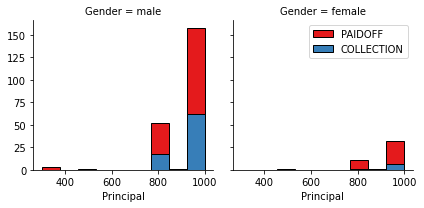

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

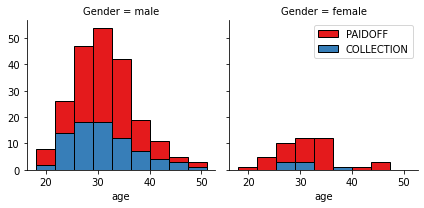

In [9]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


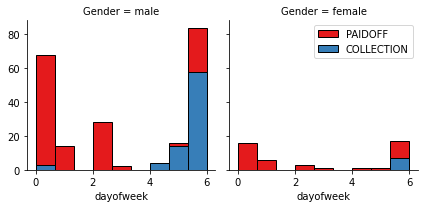

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby('Gender')['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=0)
print(x_train.shape[0])
print(x_test.shape[0])

259
87


Maximum accuracy: 0.8735632183908046 at K = 41


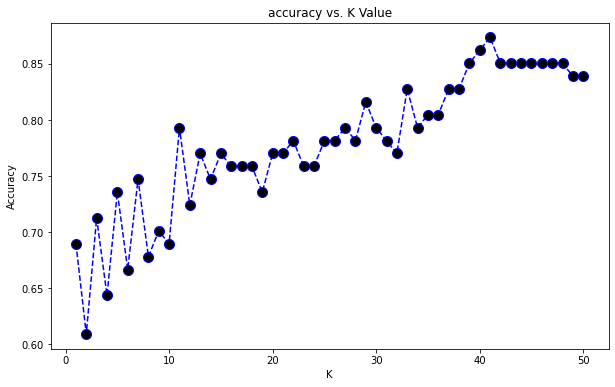

In [21]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import metrics
import matplotlib.pyplot as plt

Ks = 50
mean_acc = np.zeros((Ks))
std_acc = np.zeros((Ks))
train_mean_acc = np.zeros((Ks))
train_std_acc = np.zeros((Ks))

for n in range(1,Ks+1):
    #print(n)
    #Train Model and Predict  
    kn = KNN(n_neighbors = n).fit(x_train,y_train)
    y_pred=kn.predict(x_test)
    y_train_pred = kn.predict(x_train)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)
    train_mean_acc[n-1] = metrics.accuracy_score(y_train, y_train_pred)
    
    std_acc[n-1]=np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])
    train_std_acc[n-1]=np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])

   
plt.figure(figsize=(10,6))
plt.plot(range(1,Ks+1),mean_acc,color = 'blue',linestyle='--', 
         marker='o',markerfacecolor='k', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(mean_acc),"at K =",mean_acc.argmax()+1)
knn_k= mean_acc.argmax()+1

Min std: 0.03563069222368724 at K = 41


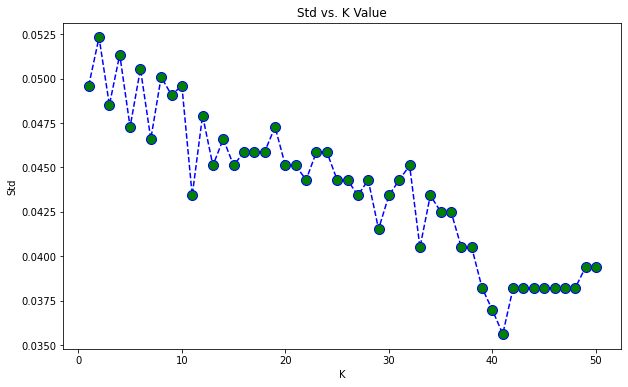

In [22]:
plt.figure(figsize=(10,6))
plt.plot(range(1,Ks+1),std_acc,color = 'blue',linestyle='--', 
         marker='o',markerfacecolor='green', markersize=10)
plt.title('Std vs. K Value')
plt.xlabel('K')
plt.ylabel('Std')
print("Min std:",min(std_acc),"at K =",std_acc.argmin()+1)

Maximum Train accuracy: 0.8918918918918919 at K = 1


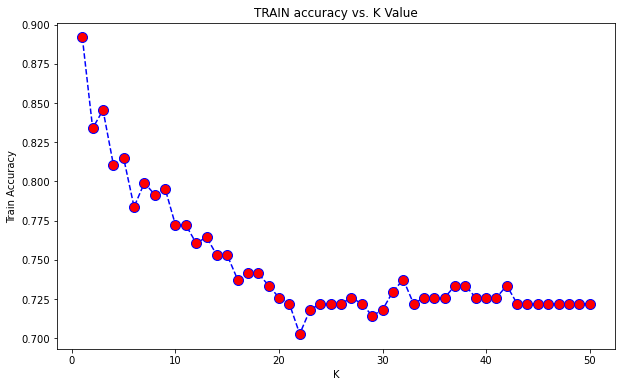

In [23]:
plt.figure(figsize=(10,6))
plt.plot(range(1,Ks+1),train_mean_acc,color = 'blue',linestyle='--', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('TRAIN accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Train Accuracy')
print("Maximum Train accuracy:",max(train_mean_acc),"at K =",train_mean_acc.argmax()+1)

In [24]:
k = knn_k
kn = KNN(n_neighbors = k).fit(x_train,y_train)
y_pred=kn.predict(x_test)
y_train_pred = kn.predict(x_train)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, y_train_pred))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred))

kn_score = metrics.accuracy_score(y_test, y_pred)
print('The maximum level of accuracy for the test set is achieved at k={}, with a score of {:.3f}'.format(knn_k,kn_score))

Train set Accuracy:  0.7258687258687259
Test set Accuracy:  0.8735632183908046
The maximum level of accuracy for the test set is achieved at k=41, with a score of 0.874


# Decision Tree


Maximum accuracy: 0.8390804597701149 at K = 1
[0.83908046 0.83908046 0.83908046 0.72413793 0.67816092]


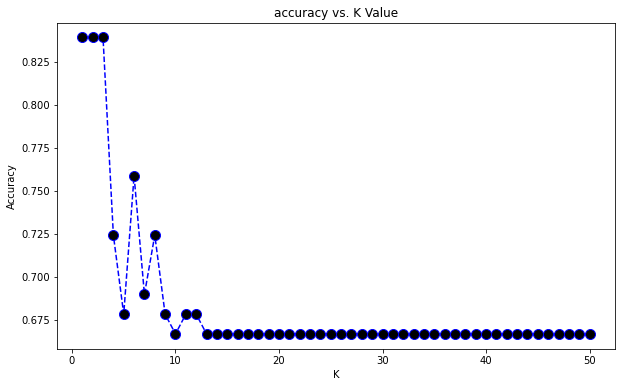

In [25]:
from sklearn.tree import DecisionTreeClassifier
Ks = 50
mean_acc = np.zeros((Ks))
std_acc = np.zeros((Ks))
train_mean_acc = np.zeros((Ks))
train_std_acc = np.zeros((Ks))

for n in range(1,Ks+1):
    #print(n)
    #Train Model and Predict  
    dtr = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(x_train,y_train)
    y_pred=dtr.predict(x_test)
    y_train_pred = dtr.predict(x_train)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)
    train_mean_acc[n-1] = metrics.accuracy_score(y_train, y_train_pred)
    
    std_acc[n-1]=np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])
    train_std_acc[n-1]=np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])

   
plt.figure(figsize=(10,6))
plt.plot(range(1,Ks+1),mean_acc,color = 'blue',linestyle='--', 
         marker='o',markerfacecolor='k', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(mean_acc),"at K =",mean_acc.argmax()+1)
dts_k= mean_acc.argmax()+1
print(mean_acc[:5])

**As the score would be the same for K=3, we will choose this value instead of K=1**

Min std: 0.03939549565857641 at K = 1


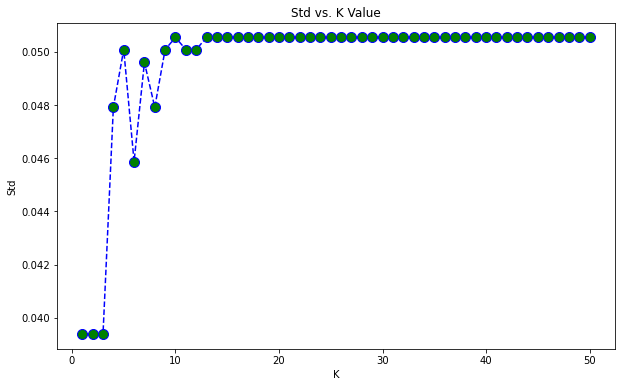

In [26]:
plt.figure(figsize=(10,6))
plt.plot(range(1,Ks+1),std_acc,color = 'blue',linestyle='--', 
         marker='o',markerfacecolor='green', markersize=10)
plt.title('Std vs. K Value')
plt.xlabel('K')
plt.ylabel('Std')
print("Min std:",min(std_acc),"at K =",std_acc.argmin()+1)

Maximum Train accuracy: 0.915057915057915 at K = 15


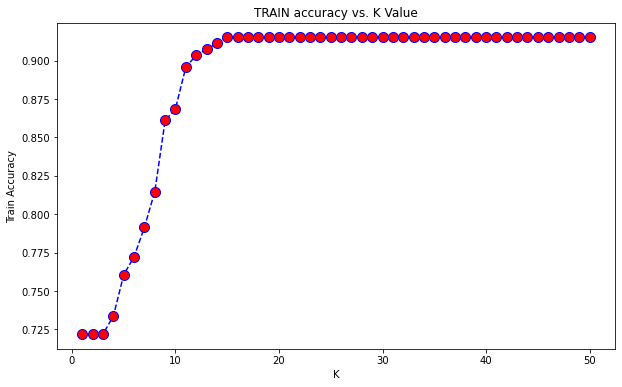

In [27]:
plt.figure(figsize=(10,6))
plt.plot(range(1,Ks+1),train_mean_acc,color = 'blue',linestyle='--', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('TRAIN accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Train Accuracy')
print("Maximum Train accuracy:",max(train_mean_acc),"at K =",train_mean_acc.argmax()+1)

In [28]:
dtr_k = 3
k= dtr_k
dtr = DecisionTreeClassifier(criterion="entropy", max_depth = k)
dtr.fit(x_train,y_train)
y_pred = dtr.predict(x_test)
dtr

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [29]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_pred))
y_pred_train = dtr.predict(x_train)
print("DecisionTrees's Accuracy under Trainset: ", metrics.accuracy_score(y_train, y_pred_train))

DecisionTrees's Accuracy:  0.8390804597701149
DecisionTrees's Accuracy under Trainset:  0.722007722007722


In [30]:
dtr_score = metrics.accuracy_score(y_test, y_pred)
print('The maximum level of accuracy for the test set is achieved at k={}, with a score of {:.3f}'.format(dtr_k,dtr_score))

The maximum level of accuracy for the test set is achieved at k=3, with a score of 0.839


# Support Vector Machine


<AxesSubplot:xlabel='education', ylabel='age'>

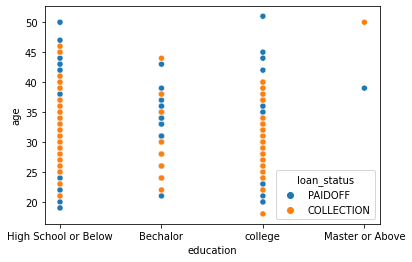

In [31]:
sns.scatterplot(x='education',y='age',data=df,marker = 'o',hue="loan_status")

In [32]:
list_gamma = list(np.linspace(0.01,1,21)) + list(np.arange(2,11,1))
list_tc = list(np.linspace(0.01,1,21)) + list(np.arange(5,250,20))
print(len(list_gamma))
print(len(list_tc))

30
34


In [33]:
from sklearn import svm
scores = []
params = []
for g in list_gamma:
    for c in list_tc:
        title = 'gamma = {:.2f}, C = {:.2f}'.format(g, c)
        clf = svm.SVC(kernel = 'rbf', gamma = g, C = c).fit(x_train, y_train)
        params.append((g,c))
        score = clf.score(x_test,y_test)
        scores.append(score)

Maximum accuracy: 0.8505747126436781 at Gamma = 0.059500000000000004


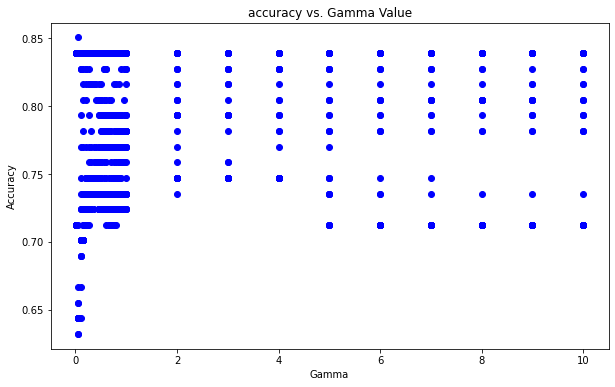

In [34]:
cs=[]
gammas=[]
for i in params:
    gammas.append(i[0])
    cs.append(i[1])
    
plt.figure(figsize=(10,6))
plt.scatter(gammas,scores,color = 'blue', 
         marker='o')
plt.title('accuracy vs. Gamma Value')
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(scores),"at Gamma =",gammas[np.array(scores).argmax()])

Maximum accuracy: 0.8505747126436781 at C = 1.0


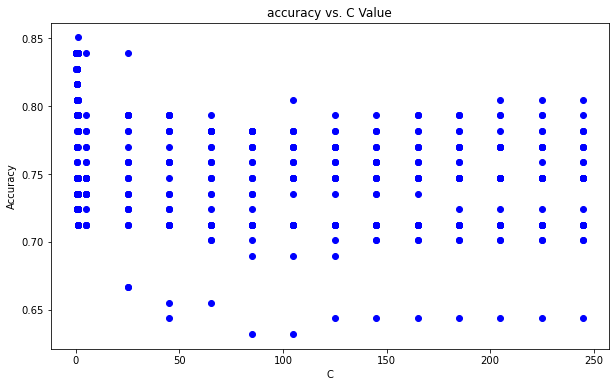

In [35]:
plt.figure(figsize=(10,6))
plt.scatter(cs,scores,color = 'blue', 
         marker='o')
plt.title('accuracy vs. C Value')
plt.xlabel('C')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(scores),"at C =",cs[np.array(scores).argmax()])

In [36]:
scores_idx = scores.index(max(scores))
maxparams = params[scores_idx]
print('Max accuracy is achieved at a value of {} with a gamma of {} and a C value of {}'.format(max(scores),round(maxparams[0],4),maxparams[1]))

Max accuracy is achieved at a value of 0.8505747126436781 with a gamma of 0.0595 and a C value of 1.0


In [37]:
c_value = maxparams[1]
gamma_value = maxparams[0]

from sklearn import svm
clf = svm.SVC(kernel='rbf',gamma=gamma_value,C=c_value)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [38]:
svm_score = metrics.accuracy_score(y_test, y_pred)
print("SVM's Accuracy: ", svm_score)
y_pred_train = clf.predict(x_train)
print("SVM's Accuracy under Trainset: ", metrics.accuracy_score(y_train, y_pred_train))

SVM's Accuracy:  0.8505747126436781
SVM's Accuracy under Trainset:  0.7297297297297297


# Logistic Regression


In [39]:
from sklearn.linear_model import LogisticRegression
list_tc = [0.0001,0.001,0.01,0.1,1,10,50,100]
list_solver = ["lbfgs", "liblinear"]

Maximum accuracy: 0.8390804597701149 at C = 0.0001


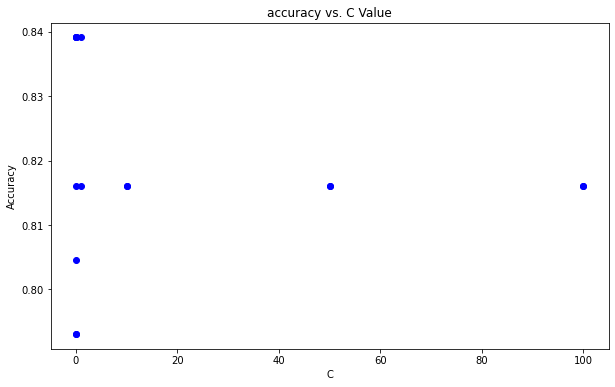

In [40]:
scores = []
cs = []
csolver = []
for i in list_tc:
    for j in list_solver:
        LR = LogisticRegression(C=i, solver=j).fit(x_train,y_train)
        y_pred = LR.predict(x_test)
        score = LR.score(x_test,y_test)
        scores.append(score)
        cs.append(i)
        csolver.append(j)
        
plt.figure(figsize=(10,6))
plt.scatter(cs,scores,color = 'blue', 
         marker='o')
plt.title('accuracy vs. C Value')
plt.xlabel('C')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(scores),"at C =",cs[np.array(scores).argmax()])

Maximum accuracy: 0.8390804597701149 at solver = lbfgs


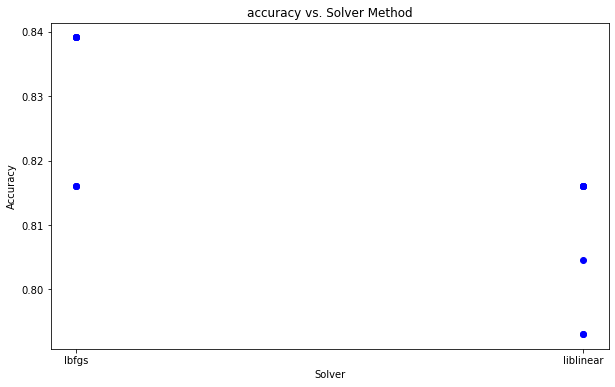

In [41]:
plt.figure(figsize=(10,6))
plt.scatter(csolver,scores,color = 'blue', 
         marker='o')
plt.title('accuracy vs. Solver Method')
plt.xlabel('Solver')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(scores),"at solver =",csolver[np.array(scores).argmax()])

In [42]:
best_c = []
for i,j in zip(list(cs),list(scores)):
    if j==max(scores):
        best_c.append(i)
        
cvalue = max(best_c)
s = csolver[np.array(scores).argmax()]
LR = LogisticRegression(C=cvalue, solver=s).fit(x_train,y_train)
y_pred = LR.predict(x_test)

In [43]:
print('Max accuracy is achieved at a value of {} with a C value of {} and a method of {}'.format(max(scores),cvalue,s))

Max accuracy is achieved at a value of 0.8390804597701149 with a C value of 1 and a method of lbfgs


In [44]:
y_pred_prob = LR.predict_proba(x_test)
y_pred_prob

array([[0.52163047, 0.47836953],
       [0.43342494, 0.56657506],
       [0.51272317, 0.48727683],
       [0.03851372, 0.96148628],
       [0.45373414, 0.54626586],
       [0.02912009, 0.97087991],
       [0.03672517, 0.96327483],
       [0.47350382, 0.52649618],
       [0.03361644, 0.96638356],
       [0.33963927, 0.66036073],
       [0.36199916, 0.63800084],
       [0.0330906 , 0.9669094 ],
       [0.4180398 , 0.5819602 ],
       [0.3312113 , 0.6687887 ],
       [0.04128247, 0.95871753],
       [0.04318438, 0.95681562],
       [0.43274083, 0.56725917],
       [0.41085833, 0.58914167],
       [0.01682501, 0.98317499],
       [0.4893148 , 0.5106852 ],
       [0.40098434, 0.59901566],
       [0.45023158, 0.54976842],
       [0.02327178, 0.97672822],
       [0.03438874, 0.96561126],
       [0.50694771, 0.49305229],
       [0.03841068, 0.96158932],
       [0.52163047, 0.47836953],
       [0.45023158, 0.54976842],
       [0.44722382, 0.55277618],
       [0.46179692, 0.53820308],
       [0.

In [45]:
lr_score =  metrics.accuracy_score(y_test, y_pred)
print("LR's Accuracy: ",lr_score)
y_pred_train = LR.predict(x_train)
print("LR's Accuracy under Trainset: ", metrics.accuracy_score(y_train, y_pred_train))

LR's Accuracy:  0.8390804597701149
LR's Accuracy under Trainset:  0.7142857142857143


In [46]:
print("KNN's Accuracy: ",round(kn_score,3))
print("DT's Accuracy: ",round(dtr_score,3))
print("SVM's Accuracy: ",round(svm_score,3))
print("LR's Accuracy: ",round(lr_score,3))

KNN's Accuracy:  0.874
DT's Accuracy:  0.839
SVM's Accuracy:  0.851
LR's Accuracy:  0.839


# Model Evaluation using Test set


In [47]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [48]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-09-01 01:48:41--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-09-01 01:48:41 (77.5 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [49]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [50]:
test_df.shape[0]

54

In [51]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df.groupby('Gender')['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

test_df[['Principal','terms','age','Gender','education']].head()

Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X_test = Feature

y_test = test_df['loan_status'].values

X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

### Measuring accuracy on Test set

In [52]:
#KN Neighbours

y_pred_kn = kn.predict(X_test)
kn_score_new = metrics.accuracy_score(y_test, y_pred_kn)
print('Accuracy Score on test_df for KNN: {:.2f}'.format(kn_score_new))

#Decision Trees

y_pred_dtr = dtr.predict(X_test)
dtr_score_new = metrics.accuracy_score(y_test, y_pred_dtr)
print('Accuracy Score on test_df for DTR: {:.2f}'.format(dtr_score_new))

#SVM

y_pred_clf = clf.predict(X_test)
clf_score_new = metrics.accuracy_score(y_test, y_pred_clf)
print('Accuracy Score on test_df for SVM: {:.2f}'.format(clf_score_new))

#LR

y_pred_lr = LR.predict(X_test)
lr_score_new = metrics.accuracy_score(y_test, y_pred_lr)
print('Accuracy Score on test_df for LR: {:.2f}'.format(lr_score_new))

Accuracy Score on test_df for KNN: 0.74
Accuracy Score on test_df for DTR: 0.74
Accuracy Score on test_df for SVM: 0.74
Accuracy Score on test_df for LR: 0.76


In [53]:
y_pred_prob_lr = LR.predict_proba(X_test)

### Jaccard Score, F1-Score and LogLoss for our models on test_df

In [54]:
#KN Neighbours

kn_jaccardscore = round(jaccard_score(y_test, y_pred_kn,pos_label='PAIDOFF'),3)
print('KNN\nJaccard score: {:.3f}'.format(kn_jaccardscore))
kn_f1score = round(f1_score(y_test, y_pred_kn, average='weighted'),3)
print('F1-score: {:.3f}\n'.format(kn_jaccardscore))

#Decision Trees

dtr_jaccardscore = round(jaccard_score(y_test, y_pred_dtr,pos_label='PAIDOFF'),3)
print('DTR\nJaccard score: {:.3f}'.format(dtr_jaccardscore))
dtr_f1score = round(f1_score(y_test, y_pred_dtr, average='weighted'),3)
print('F1-score: {:.3f}\n'.format(dtr_jaccardscore))

#SVM

svm_jaccardscore = round(jaccard_score(y_test, y_pred_clf,pos_label='PAIDOFF'),3)
print('SVM\nJaccard score: {:.3f}'.format(svm_jaccardscore))
svm_f1score = round(f1_score(y_test, y_pred_clf, average='weighted'),3)
print('F1-score: {:.3f}\n'.format(svm_jaccardscore))

#Logistic Regression

lr_jaccardscore = round(jaccard_score(y_test, y_pred_lr,pos_label='PAIDOFF'),3)
print('Logistic Regression\nJaccard score: {:.3f}'.format(lr_jaccardscore))
lr_f1score = round(f1_score(y_test, y_pred_lr, average='weighted'),3)
print('F1-score: {:.3f}'.format(lr_jaccardscore))
lr_logloss = round(log_loss(y_test, y_pred_prob_lr),3)
print('Logloss: {:.3f}'.format(lr_logloss))

KNN
Jaccard score: 0.736
F1-score: 0.736

DTR
Jaccard score: 0.741
F1-score: 0.741

SVM
Jaccard score: 0.741
F1-score: 0.741

Logistic Regression
Jaccard score: 0.755
F1-score: 0.755
Logloss: 0.477


In [59]:
list_vars = [kn_jaccardscore,dtr_jaccardscore,lr_jaccardscore,svm_jaccardscore]
list_vars[np.array(list_vars).argmax()]
print('The best classifier, according to our studio, is a Logistic Regression model that has a value of C={} and a solver method of {}, with a Jaccard Score of {}'.format(cvalue,s,lr_jaccardscore))

The best classifier, according to our studio, is a Logistic Regression model that has a value of C=1 and a solver method of lbfgs, with a Jaccard Score of 0.755


In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred_lr, labels=list(set(y)))
print('LOGISTIC REGRESSION\n\nNonnormalized Confusion matrix\n{}'.format(cm))
print (classification_report(y_test, y_pred_lr))

LOGISTIC REGRESSION

Nonnormalized Confusion matrix
[[40  0]
 [13  1]]
              precision    recall  f1-score   support

  COLLECTION       1.00      0.07      0.13        14
     PAIDOFF       0.75      1.00      0.86        40

    accuracy                           0.76        54
   macro avg       0.88      0.54      0.50        54
weighted avg       0.82      0.76      0.67        54



# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.736  | 0.736   | NA      |
| Decision Tree      | 0.741  | 0.741  | NA      |
| SVM                | 0.741  | 0.741   | NA      |
| LogisticRegression | 0.755  | 0.755   | 0.491|


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
